# Journal Profiling Part 4: Institutions

This Python notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) to extract information about the authors affiliations data linked to [publications](https://docs.dimensions.ai/dsl/datasource-publications.html) of a specific journal.

This tutorial is the fourth of a series that uses the data extracted in order to generate a 'journal profile' report. See the [API Lab homepage](https://api-lab.dimensions.ai/) for the other tutorials in this series.

In this notebook we are going to 

* Load the publications data extracted in part 1
* Focus on institutions linked to a journal: measure how often do they appear, how many affiliated authors they have etc..


In [12]:
import datetime
print("==\nCHANGELOG\nThis notebook was last run on %s\n==" % datetime.date.today().strftime('%b %d, %Y'))

==
CHANGELOG
This notebook was last run on Jan 24, 2022
==


## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the ['Getting Started' tutorial](https://api-lab.dimensions.ai/cookbooks/1-getting-started/1-Using-the-Dimcli-library-to-query-the-API.html).


In [1]:
!pip install dimcli plotly tqdm -U --quiet 

import dimcli
from dimcli.utils import *
import os, sys, time, json
from tqdm.notebook import tqdm as progress
import pandas as pd
import plotly.express as px
from plotly.offline import plot
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)

print("==\nLogging in..")
# https://digital-science.github.io/dimcli/getting-started.html#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login(key=KEY, endpoint=ENDPOINT)
dsl = dimcli.Dsl()

Searching config file credentials for 'https://app.dimensions.ai' endpoint..


==
Logging in..
Dimcli - Dimensions API Client (v0.9.6)
Connected to: <https://app.dimensions.ai/api/dsl> - DSL v2.0
Method: dsl.ini file


Finally, let's set up a folder to store the data we are going to extract: 

In [2]:
# create output data folder
FOLDER_NAME = "journal-profile-data"
if not(os.path.exists(FOLDER_NAME)):
    os.mkdir(FOLDER_NAME)

def save(df,filename_dot_csv):
    df.to_csv(FOLDER_NAME+"/"+filename_dot_csv, index=False)

## Institutions Contributing to a Journal

From our original publications dataset, we now want to look at institutions i.e. 

* getting the full list of institutions (also ones without a GRID, for subsequent analysis) linked to the journal
* publications count 
* authors count 

#### Load previously saved affiliations data
Let's reload the affiliations data from Part-1 of this tutorial series.

**NOTE** If you are using Google Colab or don't have the data available, just do the following: 
* open up the 'Files' panel in Google Colab and create a new folder `journal-profile-data`
* grab this [file](https://github.com/digital-science/dimensions-api-lab/tree/master/cookbooks/2-publications/journal-profile-data.zip), unzip it, open the enclosed folder and upload the file called `1_publications_affiliations.csv` to Google Colab ('Upload' menu or also by dragging then inside the panel window)
* move the file inside the `journal-profile-data` folder you just created 

In [3]:
affiliations = pd.read_csv(FOLDER_NAME+"/1_publications_affiliations.csv")
affiliations.head(10)

,aff_city,aff_city_id,aff_country,aff_country_code,aff_id,aff_name,aff_raw_affiliation,aff_state,aff_state_code,pub_id,researcher_id,first_name,last_name
0,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,"Center for Disease Neurogenomics, Icahn School...",New York,US-NY,pub.1144816179,NaN,Biao,Zeng
1,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,"Pamela Sklar Division of Psychiatric Genomics,...",New York,US-NY,pub.1144816179,NaN,Biao,Zeng
2,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,"Department of Genetics and Genomic Sciences, I...",New York,US-NY,pub.1144816179,NaN,Biao,Zeng
3,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,Icahn Institute for Data Science and Genomic T...,New York,US-NY,pub.1144816179,NaN,Biao,Zeng
4,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,"Department of Psychiatry, Icahn School of Medi...",New York,US-NY,pub.1144816179,NaN,Biao,Zeng
5,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,"Center for Disease Neurogenomics, Icahn School...",New York,US-NY,pub.1144816179,NaN,Jaroslav,Bendl
6,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,"Pamela Sklar Division of Psychiatric Genomics,...",New York,US-NY,pub.1144816179,NaN,Jaroslav,Bendl
7,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,"Department of Genetics and Genomic Sciences, I...",New York,US-NY,pub.1144816179,NaN,Jaroslav,Bendl
8,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,Icahn Institute for Data Science and Genomic T...,New York,US-NY,pub.1144816179,NaN,Jaroslav,Bendl
9,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,"Department of Psychiatry, Icahn School of Medi...",New York,US-NY,pub.1144816179,NaN,Jaroslav,Bendl


## Basic stats about affiliations

* count how many affiliations statements in total
* count how many affiliations have a GRID ID
* count how many unique GRID IDs we have in total

In [4]:
#
# segment the affiliations dataset
affiliations = affiliations.fillna('') 
affiliations_with_grid = affiliations.query("aff_id != ''")
affiliations_without_grid = affiliations.query("aff_id == ''")
#
# save
save(affiliations_without_grid, "4_institutions_without_grid.csv")

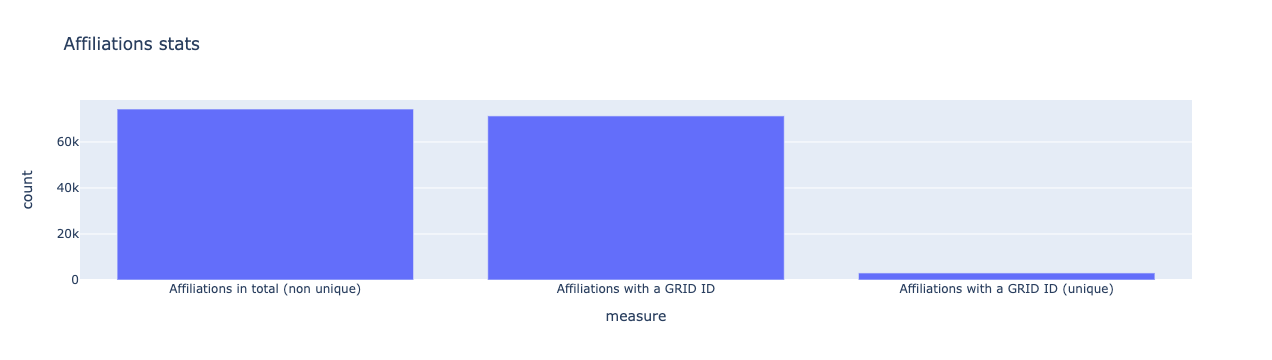

In [5]:
# build a summary barchart

df = pd.DataFrame({
    'measure' : ['Affiliations in total (non unique)', 'Affiliations with a GRID ID', 'Affiliations with a GRID ID (unique)'],
    'count' : [len(affiliations), len(affiliations_with_grid), affiliations_with_grid['aff_id'].nunique()],
})
px.bar(df, x="measure", y="count", title=f"Affiliations stats")

## Enriching the unique affiliations (GRIDs list) with pubs count and authors count

We want a table with the following columns 

* grid ID
* city
* country
* country code
* name
* tot_pubs
* tot_affiliations

NOTE: tot_affiliations is a list of 'authorships' (ie authors in the context of each publication). 

For out analysis we can start from the `gridaffiliations` dataframe. 

In [6]:
affiliations_with_grid.head(5)

,aff_city,aff_city_id,aff_country,aff_country_code,aff_id,aff_name,aff_raw_affiliation,aff_state,aff_state_code,pub_id,researcher_id,first_name,last_name
0,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,"Center for Disease Neurogenomics, Icahn School...",New York,US-NY,pub.1144816179,,Biao,Zeng
1,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,"Pamela Sklar Division of Psychiatric Genomics,...",New York,US-NY,pub.1144816179,,Biao,Zeng
2,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,"Department of Genetics and Genomic Sciences, I...",New York,US-NY,pub.1144816179,,Biao,Zeng
3,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,Icahn Institute for Data Science and Genomic T...,New York,US-NY,pub.1144816179,,Biao,Zeng
4,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,"Department of Psychiatry, Icahn School of Medi...",New York,US-NY,pub.1144816179,,Biao,Zeng


In [7]:
gridaffiliations = affiliations_with_grid.copy()
#
# group by GRIDID and add new column with affiliations count
gridaffiliations["tot_affiliations"] = gridaffiliations.groupby('aff_id')['aff_id'].transform('count')
#
# add new column with publications count, for each GRID
gridaffiliations["tot_pubs"] = gridaffiliations.groupby(['aff_id'])['pub_id'].transform('nunique')
# 
# remove unnecessary columns
gridaffiliations = gridaffiliations.drop(['aff_city_id', 'pub_id', 'researcher_id', 'first_name', 'last_name'], axis=1).reset_index(drop=True)
#
# remove duplicate rows
gridaffiliations.drop_duplicates(inplace=True)
#
# update columns order
gridaffiliations = gridaffiliations[[ 'aff_id', 'aff_name','aff_city', 
                                     'aff_country', 'aff_country_code',  'aff_state',
                                     'aff_state_code', 'tot_affiliations',  'tot_pubs']]
#
# sort
gridaffiliations = gridaffiliations.sort_values(['tot_affiliations', 'tot_pubs'], ascending=False)
#
#
# That's it! Let's see the result
gridaffiliations.head()

,aff_id,aff_name,aff_city,aff_country,aff_country_code,aff_state,aff_state_code,tot_affiliations,tot_pubs
94,grid.38142.3c,Harvard University,Cambridge,United States,US,Massachusetts,US-MA,2291,370
267,grid.38142.3c,Harvard University,Cambridge,United States,US,Massachusetts,US-MA,2291,370
1071,grid.38142.3c,Harvard University,Cambridge,United States,US,Massachusetts,US-MA,2291,370
1108,grid.38142.3c,Harvard University,Cambridge,United States,US,Massachusetts,US-MA,2291,370
1110,grid.38142.3c,Harvard University,Cambridge,United States,US,Massachusetts,US-MA,2291,370


In [8]:
# save the data
save(gridaffiliations, "4_institutions_with_grid_with_metrics.csv")

## Couple of Dataviz

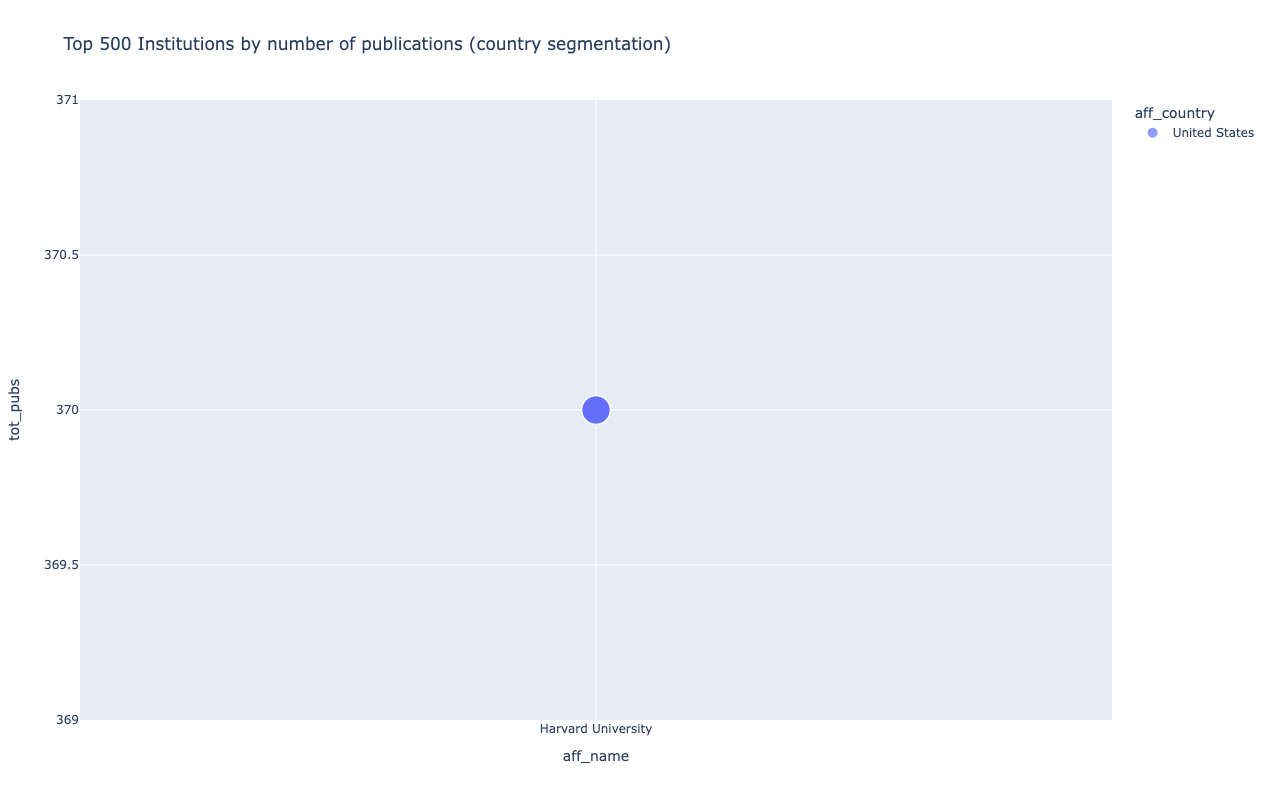

In [9]:
treshold = 500

px.scatter(gridaffiliations[:treshold], 
           x="aff_name", y="tot_pubs", 
           color="aff_country", 
           size='tot_affiliations',
           hover_name="aff_name", 
           height=800,
           hover_data=['aff_id', 'aff_name', 'aff_city', 'aff_country', 'tot_affiliations', 'tot_pubs'], 
           title=f"Top {treshold} Institutions by number of publications (country segmentation)")

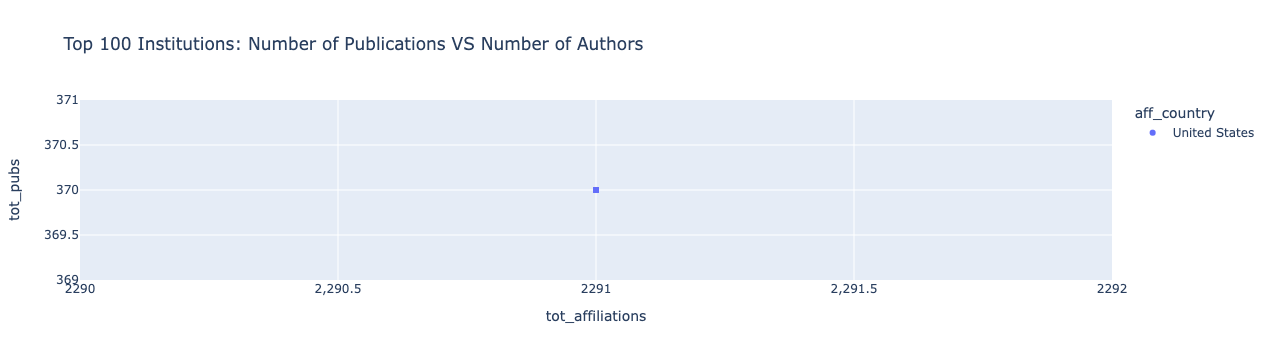

In [10]:
treshold = 100

px.scatter(gridaffiliations[:treshold], 
           x="tot_affiliations", y="tot_pubs", 
           color="aff_country",
           hover_name="aff_name", 
           hover_data=['aff_id', 'aff_name', 'aff_city', 'aff_country', 'tot_affiliations', 'tot_pubs'], 
           title=f"Top {treshold} Institutions: Number of Publications VS Number of Authors")